In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import sklearn.decomposition
import umap.umap_
import umap.plot as umapp
import bokeh.plotting as bpl
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#### variables
Batch_size = 32
Validation_split = 0.2
Epochs= 300
WEIGHTS = 'imagenet'

In [3]:
##### Data Generator 
gen_args = dict(
        rescale=1./255,
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,        
        shear_range=0.3,
        zoom_range=0.3,
        fill_mode="reflect", 
        validation_split=Validation_split
        )

In [4]:
datagen = ImageDataGenerator(**gen_args)

In [5]:
##### variables
Batch_size = 128
model_name = r'C:\Users\arthu\Desktop\Classification\Models_inMT\RESNET_BestModel_RawData_in_withBrightness_20210422_19-38-22\RESNET_BestModel_RawData_in_withBrightness_20210422_19-38-22_model.hdf5'
path = 'models/'

In [6]:
from tensorflow.keras import backend as K 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
dependencies = {
    'f1_m': f1_m}
model = tensorflow.keras.models.load_model(model_name, custom_objects = dependencies)

#model.summary()

In [8]:
model.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics=['accuracy', f1_m])

In [9]:
##### Model 
model = tensorflow.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_input (InputLayer)  [(None, 48, 48, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
Total params: 23,718,848
Trainable params: 23,665,728
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
test_generator = datagen.flow_from_directory(
        'DATA/train', 
        target_size=(48,48),
        color_mode="rgb",
        batch_size=Batch_size,
        class_mode='categorical',
        shuffle=False) 
x_test, y_test = next(test_generator)

Found 1135 images belonging to 2 classes.


In [11]:
predictions = model.predict(test_generator)
print(predictions.shape)
#909 images characterized by 64 feature vectors (in a 64 dim space)

(1135, 64)


In [12]:
def recursive_listdir(folder_path):
    file_list = []
    for root, dirs, files in os.walk(folder_path, topdown=False):
        for name in files:
                file_path = (os.path.join(root, name))
                file_list.append(file_path)
    
    return file_list

In [13]:
import re
img = recursive_listdir('DATA/train')
labels=[]
for i in range(len(img)):
    result = re.search(r'\d+', img[i])
    labels.append(int(result[0]))
    i=i+1
n=0
labels2= []
for item in labels:
    if item == 1:
        labels2.append('orange')
    else:
        labels2.append('royalblue')
array1 = np.array(labels)
print(array1.shape)

(1135,)


---

# PCA & UMAP

In [14]:
pca = sklearn.decomposition.PCA(n_components=15)
pca.fit(predictions)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.vlines(4, 0.965, 0.998, colors='red', linestyles='--', label="best model")

In [15]:
pca = sklearn.decomposition.PCA(n_components=4)
pca.fit(predictions)
x = pca.transform(predictions)

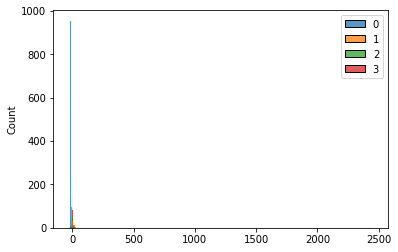

In [16]:
sns.histplot(x)

In [17]:
#print(x)

In [18]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[9.8753470e-01 6.9865272e-03 3.7240996e-03 7.3291414e-04]


In [19]:
columns = ['1', '2', '3', '4']
principalDf = pd.DataFrame(data = x
             , columns = columns)
#print(principalDf)

In [20]:
def umaper(random_state):
    mapper = umap.UMAP(random_state=random_state).fit(principalDf)
    #print(mapper)
    embedding = mapper.transform(principalDf)
    #print(embedding)
    assert(np.all(embedding == mapper.embedding_))
    #embedding.shape
    sns.set()
    #print("This is plot:", i)
    plt.figure(figsize=(15,10))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels2, s=5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP projection of the microglia reactivation states', fontsize=15)
    plt.colorbar(boundaries=np.arange(3)).set_ticks(np.arange(2))
    #plt.legend(labels=['Surveying label', 'Reactive label'], loc='best', fontsize=15)
    plt.show()
    plt.clf()
    #115

In [21]:
mapper = umap.UMAP(random_state=1).fit(principalDf)
#print(mapper)
embedding = mapper.transform(principalDf)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == mapper.embedding_))
embedding.shape
print(embedding)
# 11

[[  5.9673905  -7.850529 ]
 [  3.6507874 -10.516558 ]
 [ 11.203792   17.79784  ]
 ...
 [ 12.620198    2.5325089]
 [ 11.982535    5.515992 ]
 [ 12.720031    7.5577264]]


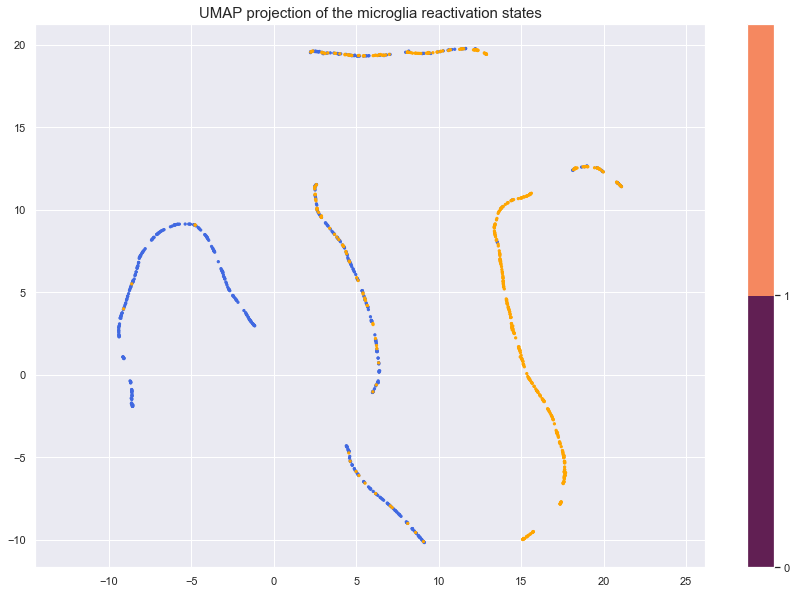

<Figure size 432x288 with 0 Axes>

In [22]:
#for i in range(0,201):
umaper(0)

In [23]:
#ax = principalDf.plot.scatter(x='principal component 1', y='principal component 2')
mapper = umap.UMAP(random_state=60).fit(principalDf)

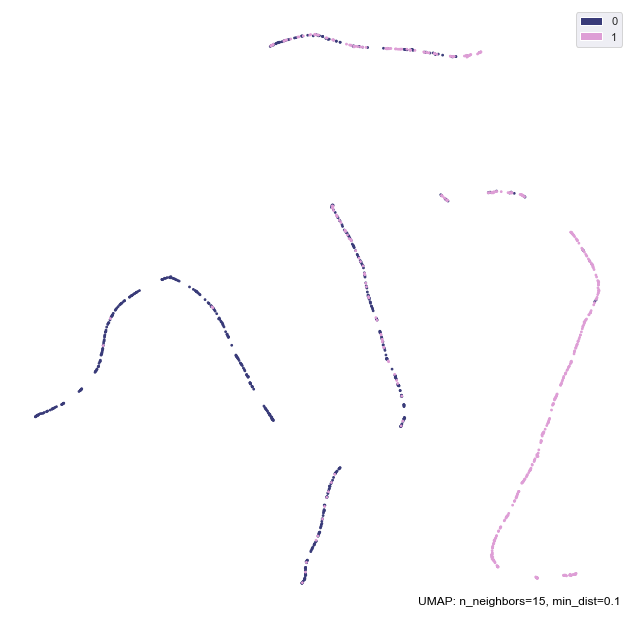

In [24]:
umapp.points(mapper, labels= array1, color_key_cmap= 'tab20b')

# to do: same thing with MNIST

---

C:\Users\arthu\anaconda3.2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\arthu\anaconda3.2\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


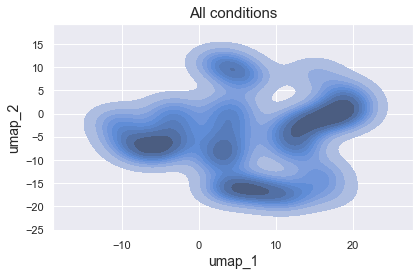

In [25]:
sns.set()
sns.kdeplot(embedding[:,0], embedding[:,1]*-1, shade=True, shade_lowest=False, cbar=False);
plt.xlabel('umap_1', fontsize=14)
plt.ylabel('umap_2', fontsize=14)
plt.title('All conditions', fontsize=15)
plt.tight_layout();

# Kernel density function

In [26]:
sns.set()

In [27]:
df = pd.read_csv(r'C:\Users\arthu\Desktop\Binary_Classification\models\model_classes.csv') #or we can directly get the prediction of a model with last layer included 
prob0 = df['Prob_0']
prob1 = df['Prob_1']
liste = []
liste.append(prob0)
liste.append(prob1)
array = np.array(liste)

In [28]:
df.head()

img_name  Label    Prob_0    Prob_1  Prediction Error (X)
0  DATA/val\0\marjan1_108.tif      0  0.999918  0.000082           0       NaN
1   DATA/val\0\marjan1_11.tif      0  0.999993  0.000007           0       NaN
2  DATA/val\0\marjan1_116.tif      0  0.999989  0.000011           0       NaN
3  DATA/val\0\marjan1_117.tif      0  0.996931  0.003070           0       NaN
4  DATA/val\0\marjan1_122.tif      0  0.999995  0.000005           0       NaN

In [29]:
print(mapper)

UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1,
     n_neighbors=15, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=60,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)


Text(0.5, 1.0, 'Kernel density estimation of microglial reactivation states')

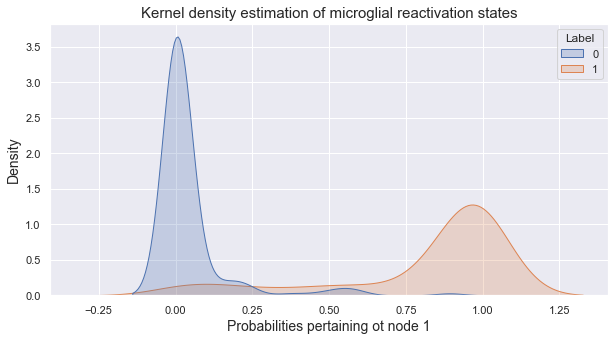

In [30]:
plt.figure(figsize=(10,5))
#sns.kdeplot(data=prob0, shade=True)
#sns.kdeplot(data=df, x="Prob_1",shade=True)
sns.kdeplot(data=df, x="Prob_1", hue="Label", shade=True)
plt.xlabel('Probabilities pertaining ot node 1', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Kernel density estimation of microglial reactivation states', fontsize=15)
#plt.legend(labels=['Reactivated label','Surveying label'], loc='best')